
# Project: Landmark Classification Using Convolutional Neural Networks


---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

This project will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end, the code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Creating a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Creating a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/data`.

Install the following Python modules:
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Creating a CNN to Classify Landmarks (from Scratch)

In this step, yow can see the steps of creating, training, and testing the CNN that classifies landmarks. The CNN is created _from scratch_ (no transfer learning).

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

Let's see how our model may do it!

### Specify Data Loaders for the Landmark Dataset

The code cell below includes creating three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `data/train` to create the train and validation data loaders, and use the images located at `data/test` to create the test data loader.

All three of your data loaders are accessible via a dictionary named `loaders_scratch`. The train data loader is at `loaders_scratch['train']`, where the validation data loader is at `loaders_scratch['valid']`, and the test data loader is at `loaders_scratch['test']`.

In [10]:
import os
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils import data
from torchvision import models

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [4]:
 def load_data(TRAIN_PATH, TEST_PATH, batch_size, size=[800,800]):
    
    transformer=transforms.Compose([
        transforms.Resize(size=size),    
        transforms.ToTensor()  ])

    # Load images from the train & test files
    train_dataset = datasets.ImageFolder(root = TRAIN_PATH, 
                    transform = transformer)
    test_dataset = datasets.ImageFolder(root = TEST_PATH, 
                    transform = transformer)

    # Define the training and validation indices to split the training dataset into train and validation
    training_samples_num = len(train_dataset)
    indices = np.array(range(training_samples_num))
    val_indices = np.random.choice(indices, size=int(training_samples_num*0.10), replace=False)

    mask = np.ones(indices.shape[0], dtype=bool)
    mask[val_indices] = False
    training_indices = indices[mask]



    # Define the batch size and sampling 
    validation_sampler = SubsetRandomSampler(val_indices)
    training_sampler = SubsetRandomSampler(training_indices)

    # Define the loaders for the 3 datasets with batch size
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sampler)
    
    # Set the loaders into dictionary
    loaders_scratch = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}
    
    return loaders_scratch

In [5]:
TRAIN_PATH = r"data/train"
TEST_PATH = r"data/test"
batch_size =  8
loaders_scratch = load_data(TRAIN_PATH, TEST_PATH, batch_size)

In [14]:
# Create a dict for each class name and index
classes = next(os.walk(TRAIN_PATH))[1]
classes_dict = {}
for class_ in classes:
    splited = class_.split('.')
    class_index = int(splited[0])
    class_name = splited[1]
    classes_dict[class_index] = class_name

classes_dict

{0: 'Haleakala_National_Park',
 1: 'Mount_Rainier_National_Park',
 2: 'Ljubljana_Castle',
 3: 'Dead_Sea',
 4: 'Wroclaws_Dwarves',
 5: 'London_Olympic_Stadium',
 6: 'Niagara_Falls',
 7: 'Stonehenge',
 8: 'Grand_Canyon',
 9: 'Golden_Gate_Bridge',
 10: 'Edinburgh_Castle',
 11: 'Mount_Rushmore_National_Memorial',
 12: 'Kantanagar_Temple',
 13: 'Yellowstone_National_Park',
 14: 'Terminal_Tower',
 15: 'Central_Park',
 16: 'Eiffel_Tower',
 17: 'Changdeokgung',
 18: 'Delicate_Arch',
 19: 'Vienna_City_Hall',
 20: 'Matterhorn',
 21: 'Taj_Mahal',
 22: 'Moscow_Raceway',
 23: 'Externsteine',
 24: 'Soreq_Cave',
 25: 'Banff_National_Park',
 26: 'Pont_du_Gard',
 27: 'Seattle_Japanese_Garden',
 28: 'Sydney_Harbour_Bridge',
 29: 'Petronas_Towers',
 30: 'Brooklyn_Bridge',
 31: 'Washington_Monument',
 32: 'Hanging_Temple',
 33: 'Sydney_Opera_House',
 34: 'Great_Barrier_Reef',
 35: 'Monumento_a_la_Revolucion',
 36: 'Badlands_National_Park',
 37: 'Atomium',
 38: 'Forth_Bridge',
 39: 'Gateway_of_India',
 40:

> Transformation is applied to resize and save images as tensors. The resize is done with (3, 800, 800) shape where the 800 is the max value found in the dataset for the images' height and width.
No augmentation is applied as we want to see the model performance by training it on the row images. However, it might be great to try some augmentation techniques like rotation, centerCrop, and flips...

### Visualize a Batch of Training Data

The code cell below retrieves a batch of images from the train data loader, display 6 images simultaneously, and label each displayed image with its class name.


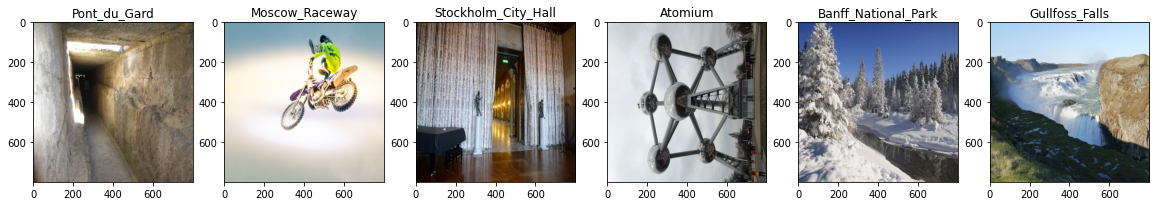

In [15]:
# Show example images from a batch
images, labels = next(iter(loaders_scratch['train']))
plt.subplots(figsize=(20, 20))

for i in range(batch_size):
    plt.subplot(1, 6, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    plt.title(classes_dict[labels[i].item()])
    
    if i >= 5: break

### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

###  Specify Loss Function and Optimizer

Define the Loss and Optimizer functions. The `CrossEntropyLoss` is a great loss function as we have a multi-class classification problem. Also, `Adam` is considered an excellent optimizer where it combines stochastic gradient descent and momentum advantages! 

In [11]:
# Define the Loss and Optimizer functions
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [12]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        maxpool = nn.MaxPool2d(2,2)
        dropout = nn.Dropout(p=0.25)
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,
                             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,
                             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,
                             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,    
                             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,
                             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                             nn.ReLU(),
                             maxpool,
                                 
                             # Fully connected Network
                             nn.Flatten(start_dim=1),
                             nn.Linear(73728, 256),
                             nn.ReLU(),
                             dropout,
                             nn.Linear(256, 128),
                             nn.ReLU(),
                             dropout,
                             nn.Linear(128, 50))
        
        
    def forward(self, x):
        ## Define forward behavior
        
        return self.cnn(x)


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Implement the Training Algorithm

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    training_loss_list = []
    valid_loss_list = []
    
    for epoch in keep_awake(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f"-------------------------------------------epoch {epoch}-------------------------------------------")
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        start = time()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            train_loss += (loss.item())
            if (batch_idx % 100 == 0):
                print('Training: batch_idx: ', batch_idx, 'out_of', len(loaders['train']))
        

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # update average validation loss 
            val_output = model(data)
            loss = criterion(val_output, target)
            valid_loss += (loss.item())
            if (batch_idx % 100 == 0):
                print('Validation: batch_idx: ', batch_idx, 'out_of', len(loaders['valid']))
        
        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])
        
        training_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime: {:.2f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time() - start
            ))

        # If the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            torch.save( model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
    # return the trained model and both the training and validation losses     
    return model, training_loss_list, valid_loss_list

### Experiment Training with the Weight Initialization

Experimenting a custom weight initialization, and then train with these weights for a few epochs.



In [ ]:
def custom_weight_init(m):
    # implement a weight initialization
    
    classname = m.__class__.__name__
   
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0.0, y)
        m.bias.data.fill_(0)
    
    # for every convolutional layer in a model..
    elif classname.find('Conv2d') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [13]:
# Train the model for 10 epochs and print the results
num_epochs = 10

saving_path = "custom_weight_init/scratch_model.pt"    
model_scratch.apply(custom_weight_init)
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch, lr=0.0001),
                      criterion_scratch, use_cuda, saving_path)

-------------------------------------------epoch 1-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 1 	Training Loss: 3.908104 	Validation Loss: 3.897269 	Time: 283.51
-------------------------------------------epoch 2-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 2 	Training Loss: 3.844790 	Validation Loss: 3.792648 	Time: 282.08
-------------------------------------------epoch 3-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx: 

### Train and Validate the Model

In [13]:
num_epochs = 75
saving_path = "default_weight_init/scratch_model.pt"    

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model with default weights for 75 epochs
model_scratch, training_loss, valid_loss = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch, lr=0.0002), 
                      criterion_scratch, use_cuda, saving_path)

-------------------------------------------epoch 1-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 1 	Training Loss: 3.914697 	Validation Loss: 3.913235 	Time: 296.17
-------------------------------------------epoch 2-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 2 	Training Loss: 3.908443 	Validation Loss: 3.886469 	Time: 281.59
-------------------------------------------epoch 3-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx: 

### Test the Model

The code cell below is to calculate and print the test loss and accuracy.  

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1] 

        correct_tensor = pred.eq(target.data.view_as(pred))
        correct += np.sum(np.squeeze(correct_tensor.numpy())) if not use_cuda else np.sum(np.squeeze(correct_tensor.cpu().numpy()))
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [13]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(saving_path))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.939369


Test Accuracy: 26% (332/1250)


Although the test Accuracy may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is.

---
<a id='step2'></a>
## Step 2: Creating a CNN to Classify Landmarks (using Transfer Learning)

In the next part, we will now use transfer learning to create a CNN that can identify landmarks from images. 

In [9]:
# Specify a new loader for transfer learning approach
loaders_transfer = load_data(TRAIN_PATH, TEST_PATH, batch_size, size=[224,224])

### Specify Loss Function and Optimizer

The loss function and the optimizer are same as the previous, except that the optimizer now should only update the output layer's weights. 

In [10]:
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model, lr):
    return torch.optim.Adam(model.fc.parameters(), lr=lr)

### Model Architecture

Use transfer learning to create a CNN to classify images of landmarks. 

In [11]:
torch.cuda.empty_cache()

In [12]:
# Download ResNet34 with pre-trained parameters
model_transfer = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [13]:
# Update the fc layer (output layer in ResNet) to match the desired output classes
model_transfer.fc = nn.Linear(in_features=512, out_features=50)

In [10]:
# Freeze all parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# Only keep the fc layer parameters updatable while training 
for param in model_transfer.fc.parameters():
    param.requires_grad = True

The `ResNet34` network is chosen to apply transfer learning and achieve better accuracy. This network could perform very well on the ImageNet dataset as well as it requires less GPU memory to train.

All the weights in the network are frozen except for the `linear` layer where the training process will update their weights to be specific for our classification problem. The `linear` layers input_features number is changed to be compatible with our dataset.

Please note that the main constrain in model training is the GPU size, where the chosen state-of-art network should meet our system capabilities.

### Train and Validate the Model

Train and validate the model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [46]:
if use_cuda:
    model_transfer.to('cuda')
    
saving_path = "model_transfer.pt"    
num_epochs = 20
model_transfer, training_loss, valid_loss = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer, lr=0.0002), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

-------------------------------------------epoch 1-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 1 	Training Loss: 3.486741 	Validation Loss: 2.831863 	Time: 106.46
-------------------------------------------epoch 2-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx:  100 out_of 563
Training: batch_idx:  200 out_of 563
Training: batch_idx:  300 out_of 563
Training: batch_idx:  400 out_of 563
Training: batch_idx:  500 out_of 563
Validation: batch_idx:  0 out_of 63
Epoch: 2 	Training Loss: 2.585259 	Validation Loss: 2.256654 	Time: 106.74
-------------------------------------------epoch 3-------------------------------------------
Training: batch_idx:  0 out_of 563
Training: batch_idx: 

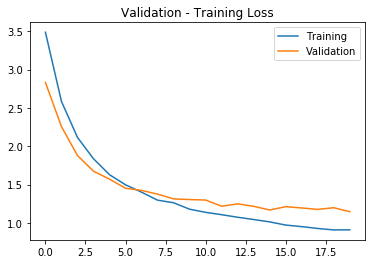

In [54]:
# Display the taining-validation loss over the 20 epochs
x = range(len(training_loss))
plt.plot(x, training_loss)
plt.plot(x, valid_loss)
plt.title("Validation - Training Loss")
plt.legend(["Training",'Validation'])

### Test the Model

Try out the trained model on the test dataset of landmark images. The code cell below calculates and prints the test loss and accuracy.

In [14]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(saving_path))

if use_cuda:
    model_transfer.to('cuda')

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.968494


Test Accuracy: 74% (926/1250)


The accuracy here is much higher than in the previous model. This is why they call it `State-of-Art`. Actually, this is because the ResNet has been already trained on a huge amount of data with a large number of epochs. The data we have also is somehow related to the ImageNet dataset, so the feature extraction layers in this network are powerful enough to achieve high accuracy in our case. 

---
<a id='step3'></a>
## Step 3: Creating Landmark Prediction Algorithm

The functions created below allows us to use the model more practically.

First, `predict_landmarks` function, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**.


In [16]:
from PIL import Image



def predict_landmarks(img_path, model, k, classes_dict):
    ## Read the image from the path
    image = Image.open(img_path)
        
    transformer = transforms.Compose([
        transforms.Resize(size=[224,224]),    
        transforms.ToTensor() ])
    # Apply transformer and move to GPU if available
    image = transformer(image)
    image = image.to('cuda') if use_cuda else image.to('cpu')
    image.unsqueeze_(0)
   
    #  Predict the landmark name and
    model.eval()
    output = model(image)
    output = output.to('cpu')
    prediction = torch.topk(output.flatten(), k).indices

    results = []
    for result in prediction.numpy():
        results.append(classes_dict[result])
    
    # Return the names of the top k landmarks predicted by the transfer learned CNN
    return results

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', model_transfer, 5, classes_dict)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Dead_Sea',
 'Sydney_Harbour_Bridge']

---

In the code cell below, the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.


Is this picture of the:
Golden_Gate_Bridge, Forth_Bridge, or Brooklyn_Bridge ?


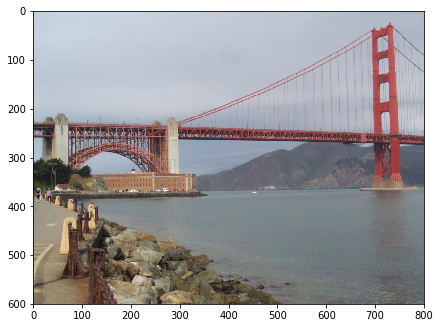

In [17]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, model_transfer, 3, classes_dict)
    
    image = Image.open(img_path)
    plt.subplots(figsize=(7, 7))
    plt.imshow(image)
    
    print("Is this picture of the:")
    print(f"{predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]} ?")

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

Is this picture of the:
Washington_Monument, Central_Park, or Petronas_Towers ?


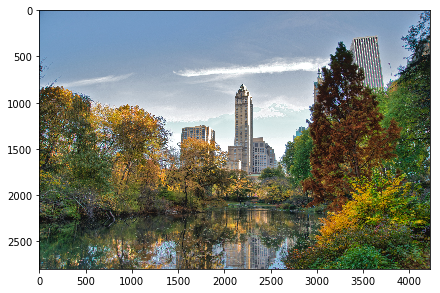

In [18]:
suggest_locations('Central_Park.jpg')

Is this picture of the:
Gullfoss_Falls, Dead_Sea, or Hanging_Temple ?


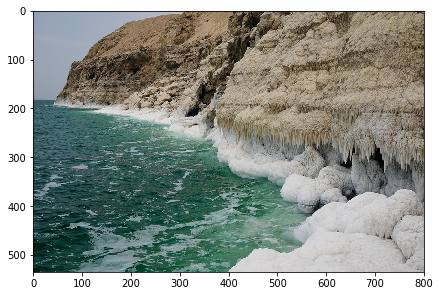

In [19]:
suggest_locations('Dead Sea.jpg')

Is this picture of the:
Delicate_Arch, Dead_Sea, or Death_Valley_National_Park ?


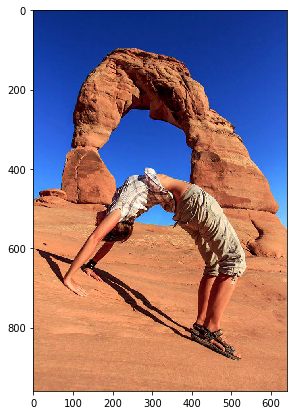

In [20]:
suggest_locations('Delicate_Arch.jpg')

Is this picture of the:
Eiffel_Tower, Vienna_City_Hall, or Edinburgh_Castle ?


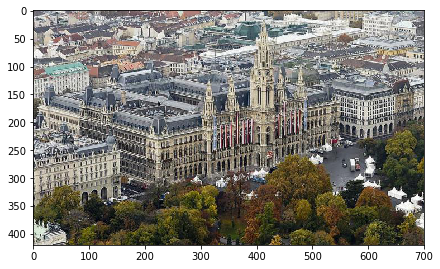

In [21]:
suggest_locations('Vienna city hall.jpg')